###### General Steps to Follow
1. Importing Packages
1. Setup Mediapipe
1. Some Data Preprocessing of The Input Video before Using DTW
1. DTW Analysis

# ------------------------------------------------------------------------------------------------------------

## 1) Importing Packages

In [1]:
import os
import sys
REPO_DIR_PATH = os.path.normpath(os.path.join(
    os.path.join(os.getcwd(), "..")))
sys.path.append(REPO_DIR_PATH)

In [19]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from src.data_preprocessing.data_transformation import DataTransformer
from scipy.signal import medfilt
from scipy.signal import find_peaks
import numpy as np
from datetime import datetime

# ------------------------------------------------------------------------------------------------------------

## 2) Setup Mediapipe

In [4]:
# Setup mediapipe instance
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [5]:
pose_model = mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

I0000 00:00:1712834365.812030   16588 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712834365.852751   16744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


###                                                              MediaPipe Poses
<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

# ------------------------------------------------------------------------------------------------------------

## 3) Some Data Preprocessing of The Input Video before Using DTW

#### 1- Get frames and angles from the video

In [6]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

In [6]:
def get_video_frames_and_angles(video_source):
    cap = cv2.VideoCapture(video_source)
    frames = []
    angles = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose_model.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks
        if results.pose_landmarks == None:
            continue
        landmarks = results.pose_landmarks.landmark

        # Get coordinates
        shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
        wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

        # Calculate angle
        angle = calculate_angle(shoulder, elbow, wrist)
        angles.append(angle)

        # Visualize angle
        height, width, _ = image.shape
        cv2.putText(image, str(round(angle,2)), 
                       tuple(np.multiply(elbow, [width+40, height+20]).astype(int)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

        # Rep data
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )   
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
            
    return frames, angles

#### 2- Apply median filter to the angles

In [8]:
def MedianFilter(angles):
    window_size = 41
    # Apply median filter to the angles_series
    denoised_angles = medfilt(angles, kernel_size=window_size)
    return denoised_angles

#### 3- Get the peaks and troughs

In [9]:
def get_peaks_and_troughs(angles):
    peaks, _ = find_peaks(angles, prominence=0.1)  # Adjust prominence threshold as needed
    troughs, _ = find_peaks(-angles, prominence=0.1)  # Find troughs by negating the angle data
    return peaks, troughs

#### 4- Get the cycles by deviding the frames according to the increasing/decreasing in the angles (peaks/troughs)

In [10]:
def get_cycles(frames, peaks):
    cycles = []
    for peak_index in range(len(peaks)-1):
        cycle = []
        cnt = peaks[peak_index]
        while True:
            cycle.append(frames[cnt])
            if cnt == peaks[peak_index+1]:
                break
            cnt+=1
        cycles.append(cycle)
    return cycles

#### 5- Convert each cycle to sequential data

In [11]:
obj = DataTransformer("bicep","poses")
def get_sequential_data(cycles):
    seq_data = []
    for cycle in cycles:
        seq = []
        for frame in cycle:
            poses = obj.get_frame_poses(frame)
            if poses == None:
                continue
            seq.append(poses)
        seq_data.append(np.array(seq))
    return seq_data

I0000 00:00:1712834570.371791   16588 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712834570.409408   16829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.161.07), renderer: NVIDIA GeForce GTX 1650/PCIe/SSE2


In [33]:
def save_cycle_frames_as_video(cycle_frames, output_path, fps=30):
    """
    Save a list of frames as a video file.
    input:
        cycle_frames(list): List of frames
        output_path(str): Output video file path
        fps(int): Frames per second
    output:
        None
    """
    try:
        # Get the shape of the first frame to determine video dimensions
        height, width, _ = cycle_frames[0].shape

        # Define the codec and create VideoWriter object
        # Choose the codec (here, MP4V)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        try:
            # Write each frame to the video file
            for frame in cycle_frames:
                out.write(frame)
        finally:
            # Release the VideoWriter object
            out.release()
    except Exception as e:
        logging.error("Error: "+str(e))
        raise CustomException(e, sys)

def save_cycles_as_videos(cycles: list):
    """
    This function will save the cycles as videos in the output directory.
    input:
        cycles(list): List of cycles
        video_name(str): Video name
    output:
        None
    """
    video_name = str(datetime.now().strftime('%Y-%m-%d-%I-%M-%S'))
    output_dir = os.path.normpath(os.path.join(
    os.path.join(os.getcwd(), "..","results","cycles_divider",video_name)))
    # Check if the directory already exists
    if not os.path.exists(output_dir):
        # Create the directory
        os.makedirs(output_dir)
    for i, cycle in enumerate(cycles):
        output_path = os.path.join(
            output_dir, video_name+"_cycle"+str(i)+".mp4")
        save_cycle_frames_as_video(cycle, output_path)

In [18]:
def data_preprocessing(video_source):
    frames, angles = get_video_frames_and_angles(video_source)
    denoised_angles = MedianFilter(angles)
    peaks, troughs = get_peaks_and_troughs(denoised_angles)
    cycles = get_cycles(frames, peaks)
    seq_data = get_sequential_data(cycles)
    return frames, angles, denoised_angles, peaks, troughs, cycles, seq_data

#### Testing the functions

In [35]:
video_source = 0
frames, angles, denoised_angles, peaks, troughs, cycles, seq_data = data_preprocessing(video_source)

In [36]:
len(cycles), seq_data[1].shape

(5, (27, 24))

In [37]:
# will be saved at results/cycles_divider
save_cycles_as_videos(cycles)

#### Plotting Peaks and Troughs

Text(0.5, 1.0, 'Angles Series with Peaks and Troughs')

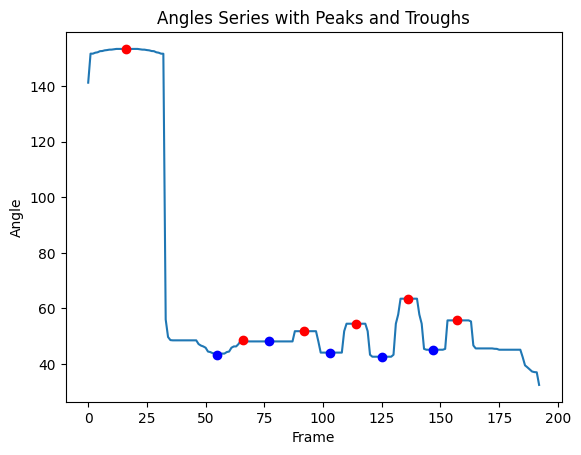

In [38]:
# Plot the angle series
plt.plot(denoised_angles, label='Angle Series')

# Plot peaks and troughs
plt.plot(peaks, denoised_angles[peaks], 'ro', label='Peaks')
plt.plot(troughs, denoised_angles[troughs], 'bo', label='Troughs')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angles Series with Peaks and Troughs')

# ------------------------------------------------------------------------------------------------------------

## 4) DTW Analysis

In [39]:
def euclidean_distance(v1, v2):
    """
    Compute the Euclidean distance between two vectors.
    
    Parameters:
        v1 (numpy.ndarray): First vector.
        v2 (numpy.ndarray): Second vector.
        
    Returns:
        float: Euclidean distance between the two vectors.
    """
    return np.linalg.norm(v1 - v2)

def dtw_distance(s1, s2):
    """
    Compute the Dynamic Time Warping (DTW) distance between two sequences of vectors.
    
    Parameters:
        s1 (numpy.ndarray): First sequence of vectors (2D array).
        s2 (numpy.ndarray): Second sequence of vectors (2D array).
        
    Returns:
        float: DTW distance between the two sequences.
    """
    # Calculate the length of each sequence
    n, m = len(s1), len(s2)
    
    # Initialize the DTW matrix with zeros
    dtw_matrix = np.zeros((n + 1, m + 1))
    
    # Fill the first row and column of the matrix with infinity
    dtw_matrix[0, 1:] = np.inf
    dtw_matrix[1:, 0] = np.inf
    
    # Calculate the DTW matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = euclidean_distance(s1[i - 1], s2[j - 1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i - 1, j], dtw_matrix[i, j - 1], dtw_matrix[i - 1, j - 1])
    
    # Return the DTW distance
    return dtw_matrix[n, m]

#### 1- Load some reference sequential data

In [42]:
def load_some_reference_seq_data():
    video_source = "../data/external/self_collected_data/bicep/criteria_1/0/4.mp4"
    reference_frames, reference_angles, reference_denoised_angles, reference_peaks, reference_troughs, reference_cycles, reference_seq_data = data_preprocessing(video_source)
    return reference_frames, reference_angles, reference_denoised_angles, reference_peaks, reference_troughs, reference_cycles, reference_seq_data

In [43]:
reference_frames, reference_angles, reference_denoised_angles, reference_peaks, reference_troughs, reference_cycles, reference_seq_data = load_some_reference_seq_data()

In [44]:
len(reference_seq_data)

5

In [45]:
reference_peaks

array([ 18,  46,  79, 112, 145, 176])

##### Plotting Peaks and Troughs

Text(0.5, 1.0, 'Angles Series with Peaks and Troughs of the Refrence Data')

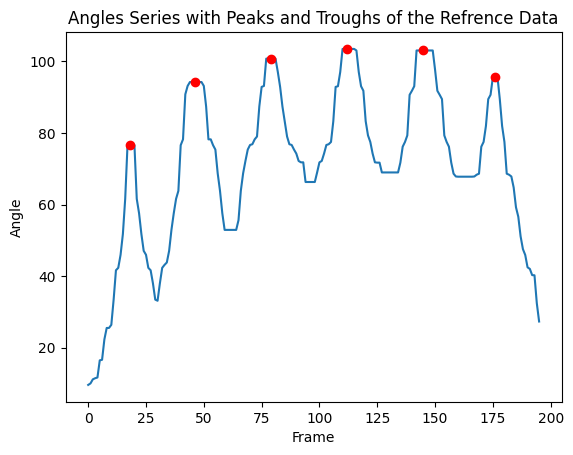

In [46]:
# Plot the angle series
plt.plot(reference_denoised_angles, label='Angle Series')

# Plot peaks and troughs
plt.plot(reference_peaks, reference_denoised_angles[reference_peaks], 'ro', label='Peaks')
#plt.plot(troughs, denoised_angles[troughs], 'bo', label='Troughs')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angles Series with Peaks and Troughs of the Refrence Data')

#### 2- Get the sequential data of the input video

In [76]:
#video_source = "../data/external/self_collected_data/bicep/criteria_1/1/7B.mp4"
video_source = 0
frames, angles, denoised_angles, peaks, troughs, cycles, seq_data = data_preprocessing(video_source)

In [77]:
len(seq_data)

7

##### Plotting Peaks and Troughs

Text(0.5, 1.0, 'Angles Series with Peaks and Troughs')

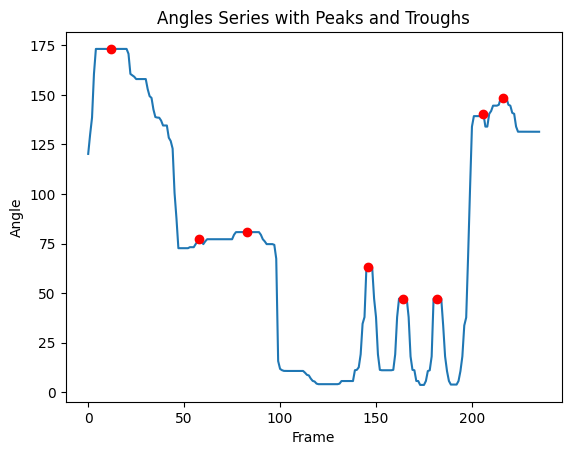

In [78]:
# Plot the angle series
plt.plot(denoised_angles, label='Angle Series')

# Plot peaks and troughs
plt.plot(peaks, denoised_angles[peaks], 'ro', label='Peaks')
#plt.plot(troughs, denoised_angles[troughs], 'bo', label='Troughs')

# Set labels and title
plt.xlabel('Frame')
plt.ylabel('Angle')
plt.title('Angles Series with Peaks and Troughs')

#### 3- Calculating the DTW distances

In [83]:
input_cycle_number = 5
ref_index = 3
dtw_distance(seq_data[input_cycle_number-1], reference_seq_data[ref_index])

48.7041201858333

In [53]:
dtw_distance(reference_seq_data[0], reference_seq_data[4])

15.209816142115638